#### Disclaimer and Link to Our Github Repo

Please find our Github repo here: [https://github.com/Eddie-Ward/cs598-DLH-team12-SAMIL](https://github.com/Eddie-Ward/cs598-DLH-team12-SAMIL) which includes this notebook as well as instructions to setup to run this notebook.

For this submission, we could not setup a Colab environment for a number of reasons including that our dataset is not public and the computational requirements for the model are too large. Because the dataset is not public, we have included instructions for applying for dataset access in our repo as well as code below to generate synthetic, fake data so that this notebook is still runnable.


# Introduction

This project seeks to innovate the diagnostic process for Aortic Stenosis (AS)—a degenerative heart valve disease with significant health implications if left undetected and untreated. AS is characterized by the narrowing of the aortic valve, obstructing blood flow from the left ventricle to the aorta and, ultimately, the rest of the body. Traditionally, diagnosing AS has relied on manual analysis of transthoracic echocardiography, a process that yields a vast array of ultrasound images. Yet, only a subset of these images actually depicts the aortic valve with sufficient clarity to assess the condition. The labor-intensive nature of this process, coupled with the need for specialized medical expertise, often leads to under-diagnosis.

The original paper introduces a novel, end-to-end supervised attention Multiple Instance Learning (MIL) methodology for the automatic screening of AS. The core innovation lies in two main areas: a supervised attention technique that focuses the MIL model on images relevant to AS diagnosis, and a pioneering self-supervised pretraining strategy that enhances the model's ability to interpret a "bag" of images rather than individual instances. This approach not only aims to streamline the diagnostic process but also strives for greater accuracy, as evidenced by its performance on an open-access echocardiogram dataset. The contributions of this research hold the potential to substantially reduce the barriers to effective AS screening, offering a more systematic and reproducible alternative to current methods.


# Scope of Reproducibility

The scope of our project aims to replicate the results of the original paper "Detecting Heart Disease from Multi-View Ultrasound Images via Supervised Attention Multiple Instance Learning" by Huang, Wessler, and Hughes (PMLR, 2023). Our objective is to use the code and dataset provided to reproduce the tables that evaluate the attention strategy and the pretraining strategy. We aim to validate the paper's claim that the Supervised Attention Multiple Instance Learning (SAMIL) model exhibits higher balanced accuracy in automatic diagnosis compared to other models.

The paper reports balanced accuracy on the following ablations based on their two novel contributions to attention-based MIL. The base, existing state-of-the-art attention-based MIL model to compare SAMIL against is `ABMIL`, which is described in a separate paper and repo [here](https://github.com/AMLab-Amsterdam/AttentionDeepMIL/tree/master). There is a variant called `Gated ABMIL` that is also evaluated in the original paper; however, we have chosen not to train this model due to computation constraints as well as the paper's reported findings that this variant did not improve on base `ABMIL`.

The first contribution is the supervised-attention mechanism of SAMIL, labeled as `SAMIL no pretrain`. The second is self-supervised pretraining by adapting a state-of-the-art pretraining strategy called MoCo to a bag-level. The original MoCo task pretrains for instance-level embeddings, and is labeled here as `SAMIL img-CL`. The paper's proposed MoCo variant for bag-level embeddings is labeled here as `SAMIL bag pretrain`. Due to computation feasibility constraints, we are only reproducing results for 1 of the 3 cross-validation splits reported in the paper.

| Ablation           | Reported Bal. Acc. |
| ------------------ | ------------------ |
| ABMIL              | 58.5               |
| SAMIL no pretrain  | 72.7               |
| SAMIL img-CL       | 71.2               |
| SAMIL bag pretrain | 75.4               |


# Methodology

Our GitHub repo is located here: [https://github.com/Eddie-Ward/cs598-DLH-team12-SAMIL](https://github.com/Eddie-Ward/cs598-DLH-team12-SAMIL)

The original paper's Github repo is located here: [https://github.com/tufts-ml/SAMIL](https://github.com/tufts-ml/SAMIL)

Please follow the setup instructions there including acquiring dataset access, downloading their pretrained checkpoints, and setting up the Conda environment with a provided `environment.yml` file.

**Note**: You will need to download the pretrained checkpoints of the view classifier, MoCo img-CL, and MoCo bag pretrained in order for the respective training and testing loops to work below. The link to download is on their Github, and is included [here](https://tufts.app.box.com/s/c5w8123j7h3dpls75jye1363uh8qv8us). We have chosen not to re-upload those checkpoints ourselves. You will also need to download the split and summary CSVs for the TMED-2 dataset which can be found in the `data_info` folder in the original repository.


## Environment


#### Download Saved Checkpoints

We provide the option to automatically download our saved checkpoints using `gdown`, or if that doesn't work, the Drive link to manually download our archived runs is [here](https://drive.google.com/drive/folders/1zy9JNd9pbQJhMTkI03AuhuU7Ntf7dpgc?usp=drive_link).

If you are manually downloading, make sure to update the `ARCHIVED_RUNS_DIR` variable in the code below accordingly.


In [ ]:
# Run this cell to automatically download our saved checkpoints with gdown
import gdown

ABMIL_folder_id = "1XEKhFgUbxcPMRxhYgM0rxQSgmRxwnGqw"
gdown.download_folder(id=ABMIL_folder_id, output="./model_runs_gdown/ABMIL-52.5")

SAMIL_folder_id = "1QBoMGcWC1zWu7cWqB06Zq6dgcL_11HQ_"
gdown.download_folder(id=SAMIL_folder_id, output="./model_runs_gdown/SAMIL-70.2")

SAMIL_imgcl_folder_id = "1_4rQSxKpx079Giu1kggQGHU4zNhUrjbx"
gdown.download_folder(
    id=SAMIL_imgcl_folder_id, output="./model_runs_gdown/SAMIL-imgcl-70.3"
)

SAMIL_bag_pretrain_folder_id = "1aE8Iv0c_nAD5g4sqBwkvGXWy0tMIINAH"
gdown.download_folder(
    id=SAMIL_bag_pretrain_folder_id, output="./model_runs_gdown/SAMIL-bag-pretrain-72.9"
)

In [1]:
import os

DOWNLOADED_RUNS_DIR = os.path.join(
    "./model_runs_archived"
)  # Use this if you are manually downloading saved checkpoints, use this folder
GDOWN_RUNS_DIR = os.path.join(
    "./model_runs_gdown"
)  # Use this if you are running the gdown code to automatically download saved checkpoints

ARCHIVED_RUNS_DIR = GDOWN_RUNS_DIR  # Change between the two variables accordingly. ARCHIVED_RUNS_DIR is the global path variable referenced in the Results section

#### Setup: Python Version and Dependencies

The provided `environment.yml` file includes the dependencies required.

Generally, we are using Python 3.12.2 and PyTorch 2.2.2. The original repo specifies PyTorch 1.11.0, but we have adapted the code to the latest version. We anticipate that later versions of dependencies will not create any problems as we ensure to not use any modules that could be deprecated in the future (e.g. see the section Data Processing: Transform Functions).

We trained with a discrete GPU with Cuda acceleration, but the notebook will correctly adapt to a CPU-environment in the code below.


In [2]:
import math
import glob
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from tqdm import tqdm

In [3]:
# Modify these if you have a different folder structure than the recommended one
DATA_INFO_DIR = os.path.join("./data_info")
DATA_DIR = os.path.join("./echo_data")
CHECKPOINTS_DIR = os.path.join("./model_checkpoints")
RUNS_DIR = os.path.join("./model_runs")

In [4]:
if torch.cuda.is_available():
    print("Cuda is available")
    DEVICE = torch.device("cuda")

    # May improve performance if GPU is Ampere architecture or later
    # Comment these lines out if PyTorch fails
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
else:
    print("Cuda is not available, using CPU")
    DEVICE = torch.device("cpu")

Cuda is available


In [5]:
# Setting the random seed to what is specified in original paper's repo
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Data


#### Source

The dataset is from the TMED-2 dataset available here for approved users that apply on the website: https://tmed.cs.tufts.edu/tmed_v2.html

This paper specifically uses the `view_and_diagnosis_labeled_set` although parts of the model are pretrained using other sets.

The dataset consists of three hierarchies: `patient`, `study`, and `image`. Each `patient` can have multiple `studies` recorded on different days. Each `study` consists of `images` of different ultrasound views of the `patient`'s heart obtained through ECG (echocardiogram). The images are codified in the following format: `<patient_id>s<study_id>_<image_id>` e.g. `9s1_0.png` indicates `patient_id = 9`, `study_id = 1`, and `image_id = 0`. Patient IDs are universally unique in the entire TMED-2 dataset, but study IDs (`study_id = 1` indicates the first study of that patient) and image IDs are not (even across the labeled and unlabeled set of the same study).

For labels, the dataset has 3 labels: 0 = no AS, 1 = mild to moderate AS, and 2 = severe AS.

Due to computation feasibility constraints, we are only using `Split 1` out of the 3 available DEV479 CV splits. DEV479 splits consist of 360 train studies, 119 val studies, and 120 test studies (called DEV479 because 360 + 119 = 479). These are pre-defined and specified in CSVs available from the original GitHub repo.

**Note**: Run the following two blocks only if you have access to the dataset and have correctly imported it into the repo.
Otherwise, there will be code below to generate random, synthetic data for use in verifying training and evaluation code.


In [6]:
# DO NOT RUN IF YOU DO NOT HAVE THE DATASET

TMED2_SUMMARY_TABLE = pd.read_csv(os.path.join(DATA_INFO_DIR, "TMED2SummaryTable.csv"))

SEED_DIR = os.path.join(
    DATA_INFO_DIR, "seed0"
)  # Change this if using another seed (train/val/test split)

TRAIN_SPLIT = pd.read_csv(os.path.join(SEED_DIR, "train_studies.csv"))
VAL_SPLIT = pd.read_csv(os.path.join(SEED_DIR, "val_studies.csv"))
TEST_SPLIT = pd.read_csv(os.path.join(SEED_DIR, "test_studies.csv"))

train_study_ids = TRAIN_SPLIT["study"].values
val_study_ids = VAL_SPLIT["study"].values
test_study_ids = TEST_SPLIT["study"].values

In [7]:
# DO NOT RUN IF YOU DO NOT HAVE THE DATASET
# Sanity test for number of studies for each split

assert len(train_study_ids) == 360
assert len(val_study_ids) == 119
assert len(test_study_ids) == 120

#### Custom Dataset Class: EchoDataset


In [8]:
import PIL
from PIL import Image


class EchoDataset(Dataset):
    def __init__(
        self,
        study_ids: pd.DataFrame,
        summary_table: pd.DataFrame,
        data_dir: str,
        transform_fn=None,
        empty=False,
    ):
        self.study_ids = study_ids
        self.summary_table = summary_table
        self.data_dir = data_dir
        self.transform_fn = transform_fn
        self.diagnosis_to_label = {
            "no_AS": 0,
            "mild_AS": 1,
            "mildtomod_AS": 1,
            "moderate_AS": 2,
            "severe_AS": 2,
        }

        self.bag_of_study_images = []
        self.bag_of_study_labels = []

        if not empty:
            self.bag_of_study_images, self.bag_of_study_labels = self._create_bags()

    def _create_bags(self):
        bag_of_study_images = []
        bag_of_study_labels = []

        for study_id in self.study_ids:
            summary_record = self.summary_table[
                self.summary_table["patient_study"] == study_id
            ]

            label = list(set(summary_record["diagnosis_label"].values))
            assert len(label) == 1, "every study should only have one diagnosis label"

            label = label[0]
            assert label in self.diagnosis_to_label, "every label should be valid"

            label = self.diagnosis_to_label[label]
            pattern = study_id + "_*.png"

            labeled_images_paths: list[str] = glob.glob(
                pathname=pattern, root_dir=os.path.join(self.data_dir, "labeled")
            )
            unlabeled_images_paths: list[str] = glob.glob(
                pathname=pattern, root_dir=os.path.join(self.data_dir, "unlabeled")
            )

            if len(labeled_images_paths) == 0 and len(unlabeled_images_paths) == 0:
                print(f"Couldn't find images for {study_id}")
                continue

            labeled_images_paths.sort()
            unlabeled_images_paths.sort()

            study_images = []

            for image_path in labeled_images_paths:
                study_images.append(self._get_image_data(image_path, "labeled"))

            for image_path in unlabeled_images_paths:
                study_images.append(self._get_image_data(image_path, "unlabeled"))

            study_images = np.array(study_images)

            bag_of_study_images.append(study_images)
            bag_of_study_labels.append(label)

        return bag_of_study_images, bag_of_study_labels

    def _get_image_data(self, file_name: str, folder_name: str):
        abs_image_path = os.path.join(self.data_dir, folder_name, file_name)
        image_data = Image.open(abs_image_path)
        image_arr = np.array(image_data.convert(mode="RGB"))

        assert image_arr.shape == (112, 112, 3), "Images should all be 112 x 112 RGB"
        assert not np.any(
            (image_arr < 0) | (image_arr > 255)
        ), "Images should not have negative or invalid RGB values"

        return image_arr

    def __len__(self):
        return len(self.bag_of_study_labels)

    def __getitem__(self, index):
        study_images = self.bag_of_study_images[index]
        study_label = self.bag_of_study_labels[index]

        if self.transform_fn is not None:
            images_list = [
                self.transform_fn(Image.fromarray(image, mode="RGB"))
                for image in study_images
            ]
            study_images = torch.stack(images_list)

        return study_images, study_label

#### Data Processing: Transform Functions

We are using the transform functions defined in the paper's original GitHub including an option to normalize images.
For the standard train dataset, images will go through a `RandomCrop` and `RandomHorizontalFlip`. Based on the original Github, these transformations are used for ABMIL.

For the `RandAug` train dataset, images will go through a random selection of transformations. Based on the original GitHub, this variation of the train dataset was used in the MoCo pretraining task and SAMIL runs. Because the original GitHub provides only saved checkpoints and does not provide implementation code for training the view classifier or for MoCo pretraining, we are also using `RandAug` for all SAMIL runs.

**Note**: We have adapted the code to the `v2` module of `torchvision.transforms`. As such, soon-to-be deprecated methods like `transforms.toTensor()` are changed.


In [9]:
# RandAug transformation class
from PIL import ImageOps, ImageEnhance, ImageDraw

PARAMETER_MAX = 10


def AutoContrast(img, **kwarg):
    return ImageOps.autocontrast(img)


def Brightness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return ImageEnhance.Brightness(img).enhance(v)


def Color(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return ImageEnhance.Color(img).enhance(v)


def Contrast(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return ImageEnhance.Contrast(img).enhance(v)


def Cutout(img, v, max_v, bias=0):
    if v == 0:
        return img
    v = _float_parameter(v, max_v) + bias
    v = int(v * min(img.size))
    return CutoutAbs(img, v)


def CutoutAbs(img, v, **kwarg):
    w, h = img.size
    x0 = np.random.uniform(0, w)
    y0 = np.random.uniform(0, h)
    x0 = int(max(0, x0 - v / 2.0))
    y0 = int(max(0, y0 - v / 2.0))
    x1 = int(min(w, x0 + v))
    y1 = int(min(h, y0 + v))
    xy = (x0, y0, x1, y1)
    # gray
    color = (127, 127, 127)
    img = img.copy()

    ImageDraw.Draw(img).rectangle(xy, color)
    return img


def Equalize(img, **kwarg):
    return ImageOps.equalize(img)


def Identity(img, **kwarg):
    return img


def Invert(img, **kwarg):
    return ImageOps.invert(img)


def Posterize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return ImageOps.posterize(img, v)


def Rotate(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.rotate(v)


def Sharpness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return ImageEnhance.Sharpness(img).enhance(v)


def ShearX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def Solarize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return ImageOps.solarize(img, 256 - v)


def SolarizeAdd(img, v, max_v, bias=0, threshold=128):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    img_np = np.array(img).astype(np.int)
    img_np = img_np + v
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return ImageOps.solarize(img, threshold)


def TranslateX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[0])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[1])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)


def fixmatch_augment_pool():
    # FixMatch paper
    augs = [
        (AutoContrast, None, None),
        (Brightness, 0.9, 0.05),
        (Color, 0.9, 0.05),
        (Contrast, 0.9, 0.05),
        (Equalize, None, None),
        (Identity, None, None),
        (Posterize, 4, 4),
        (Rotate, 30, 0),
        (Sharpness, 0.9, 0.05),
        (ShearX, 0.3, 0),
        (ShearY, 0.3, 0),
        (Solarize, 256, 0),
        (TranslateX, 0.3, 0),
        (TranslateY, 0.3, 0),
    ]
    return augs


class RandAugmentMC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            v = np.random.randint(1, self.m)
            if random.random() < 0.5:
                img = op(img, v=v, max_v=max_v, bias=bias)
        img = CutoutAbs(img, int(32 * 0.5))
        return img

In [10]:
# Transform functions, can optionally choose to normalize datasets

from torchvision.transforms import v2 as transforms

normalized_mean = [0.059, 0.059, 0.059]
normalized_std = [0.138, 0.138, 0.138]

transform_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(
            size=112, padding=int(112 * 0.125), padding_mode="reflect"
        ),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        # transforms.Normalize(mean=normalized_mean, std=normalized_std),
    ]
)

transform_randaug_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(
            size=112, padding=int(112 * 0.125), padding_mode="reflect"
        ),
        RandAugmentMC(n=2, m=10),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
    ]
)

transform_eval = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        # transforms.Normalize(mean=normalized_mean, std=normalized_std),
    ]
)

#### Loading Datasets

Run one of the below code blocks depending on if you have access to the dataset or not.

If you do not have access to the dataset, the first block will generate fake datasets with random noise images and random labels so that you can still run the training and eval code.


In [ ]:
# RUN IF YOU DO NOT HAVE THE DATASET AND WANT TO GENERATE RANDOM DATA FOR VERIFYING CODE
def seed_fake_data(dataset: EchoDataset, num_studies=20, max_num_images=10):
    rand_bag_labels = []
    rand_bag_images = []
    for _ in range(num_studies):
        rand_bag_labels.append(random.randrange(0, 3))
        rand_images = []

        max_images = random.randrange(1, max_num_images)
        for _ in range(max_images):
            rand_images.append(np.random.rand(112, 112, 3))

        rand_images = np.array(rand_images)
        rand_bag_images.append(rand_images)

    dataset.bag_of_study_images = rand_bag_images
    dataset.bag_of_study_labels = rand_bag_labels


train_dataset = EchoDataset(None, None, "", transform_fn=transform_train, empty=True)
train_randaug_dataset = EchoDataset(
    None, None, "", transform_fn=transform_randaug_train, empty=True
)
val_dataset = EchoDataset(None, None, "", transform_fn=transform_eval, empty=True)
test_dataset = EchoDataset(None, None, "", transform_fn=transform_eval, empty=True)

seed_fake_data(train_dataset)
seed_fake_data(train_randaug_dataset)
seed_fake_data(val_dataset)
seed_fake_data(test_dataset)

In [11]:
# DO NOT RUN IF YOU DO NOT HAVE THE DATASET

train_dataset = EchoDataset(
    train_study_ids, TMED2_SUMMARY_TABLE, DATA_DIR, transform_fn=transform_train
)
print(f"Number of train studies: {len(train_dataset)}")

train_randaug_dataset = EchoDataset(
    train_study_ids, TMED2_SUMMARY_TABLE, DATA_DIR, transform_fn=transform_randaug_train
)
print(f"Number of train (randaug) studies: {len(train_randaug_dataset)}")

val_dataset = EchoDataset(
    val_study_ids, TMED2_SUMMARY_TABLE, DATA_DIR, transform_fn=transform_eval
)
print(f"Number of eval studies: {len(val_dataset)}")

test_dataset = EchoDataset(
    test_study_ids, TMED2_SUMMARY_TABLE, DATA_DIR, transform_fn=transform_eval
)
print(f"Number of test studies: {len(test_dataset)}")

Number of train studies: 360
Number of train (randaug) studies: 360
Number of eval studies: 119
Number of test studies: 120


#### Dataset Statistics

Running the below code can provide some statistics such as counts for each diagnosis in the set and the mean number of images per study.
Notably, the train dataset suffers from both fewer studies with no_AS as well as a smaller mean bag size (number of images per study) for those fewer studies, showing that the TMED-2 dataset is imbalanced.

Additionally, there is code to preview some images from the test set.


In [12]:
# Dataset Statistics
code_to_diagnosis = ["no_AS", "mod_AS", "sev_AS"]

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)


def get_stats(data_loader: DataLoader, mapping: list[str], dataset_name: str):
    label_counts = [0, 0, 0]
    bag_sizes = [[], [], []]

    for data, label in data_loader:
        label_counts[label.item()] += 1
        bag_sizes[label.item()].append(data.shape[1])

    bag_sizes = [np.array(bag_size) for bag_size in bag_sizes]
    bag_sizes = [np.mean(bag_size) for bag_size in bag_sizes]

    print(dataset_name)

    for i, diagnosis in enumerate(mapping):
        print(
            f"{diagnosis}\t: count = {label_counts[i]},\t mean bag size = {bag_sizes[i]}"
        )

    print()


get_stats(train_loader, code_to_diagnosis, "Train Set")
get_stats(val_loader, code_to_diagnosis, "Validation Set")
get_stats(test_loader, code_to_diagnosis, "Test Set")

Train Set
no_AS	: count = 76,	 mean bag size = 68.48684210526316
mod_AS	: count = 103,	 mean bag size = 75.87378640776699
sev_AS	: count = 181,	 mean bag size = 74.62983425414365

Validation Set
no_AS	: count = 25,	 mean bag size = 73.24
mod_AS	: count = 34,	 mean bag size = 72.08823529411765
sev_AS	: count = 60,	 mean bag size = 72.76666666666667

Test Set
no_AS	: count = 26,	 mean bag size = 67.92307692307692
mod_AS	: count = 34,	 mean bag size = 71.11764705882354
sev_AS	: count = 60,	 mean bag size = 75.0



In [13]:
# Code for previewing dataset images and labels (based off HW03 - CNN)
# Run the cell below to preview images from the datasets

code_to_diagnosis = ["no_AS", "mod_AS", "sev_AS"]


def imgshow(img, label_index, mapping):
    np_img = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis("off")
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title(mapping[label_index])
    plt.show()


def show_study_images(iter_loader, k=8):
    images, labels = next(iter_loader)
    images = images.squeeze(0)
    images = images[:k]

    img = torchvision.utils.make_grid(images, padding=25)
    imgshow(img, labels.item(), code_to_diagnosis)

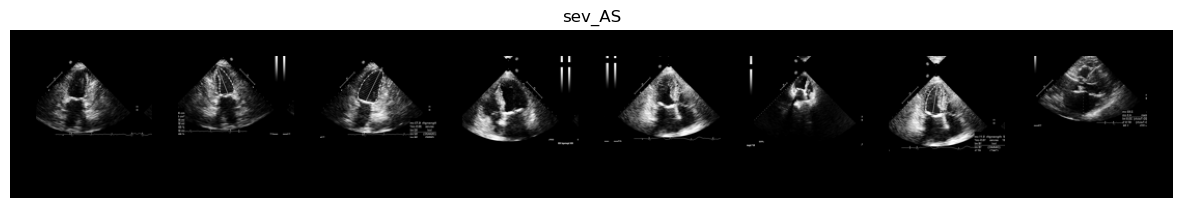

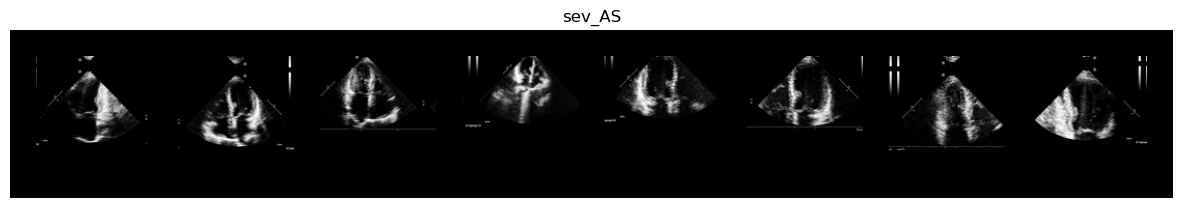

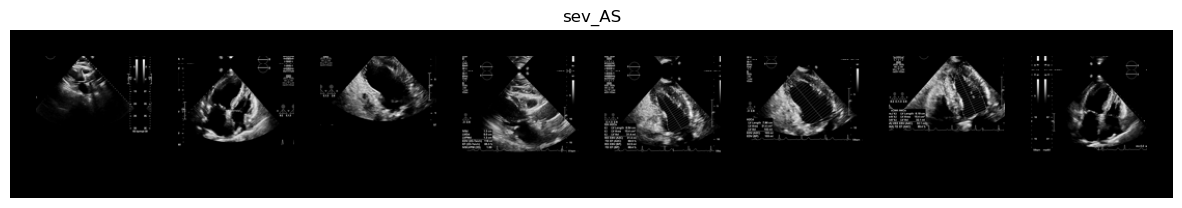

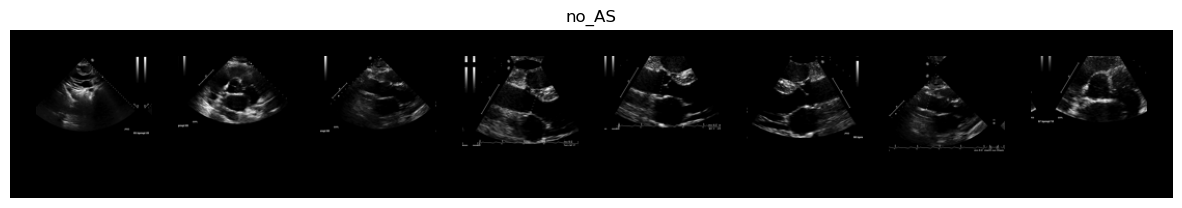

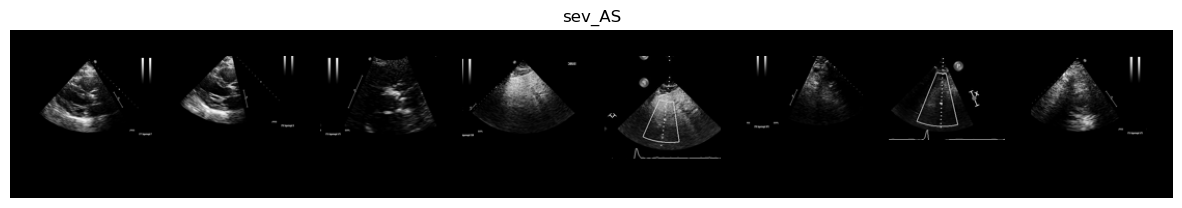

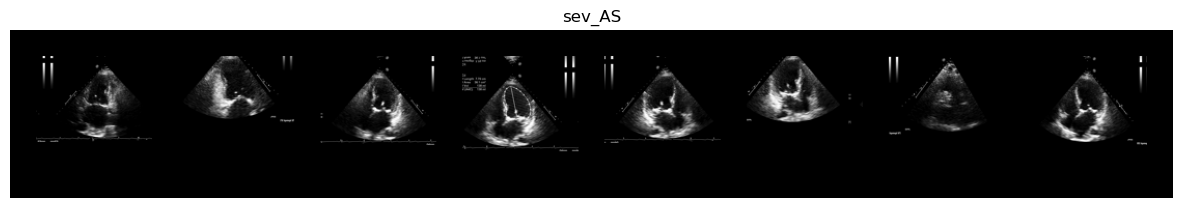

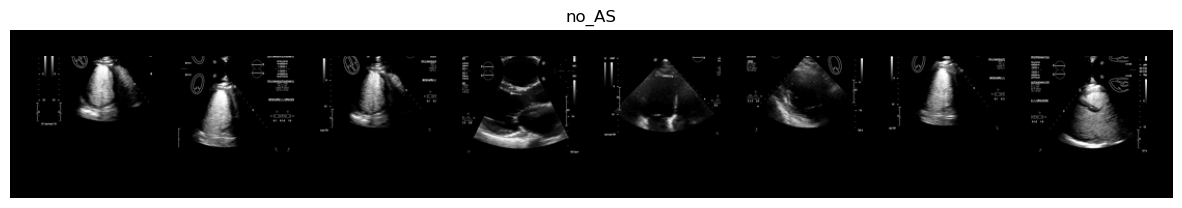

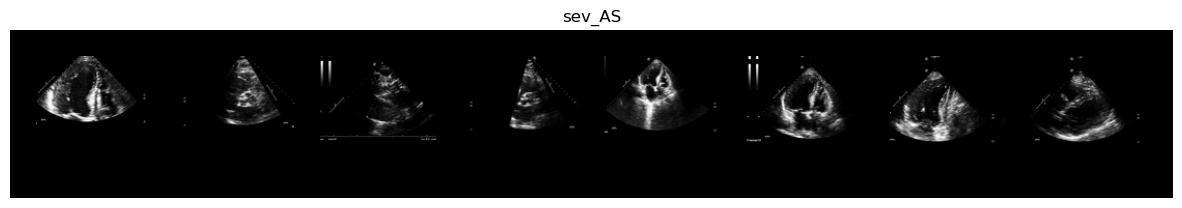

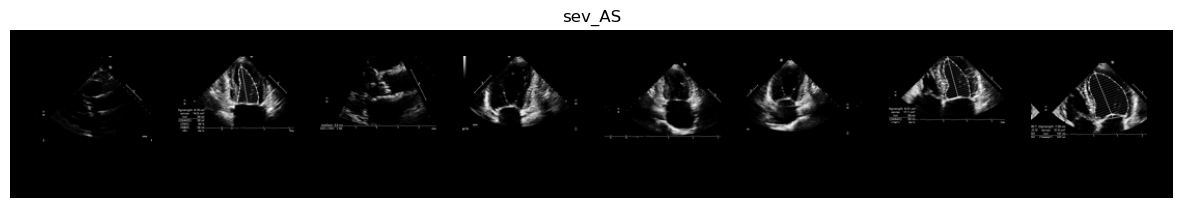

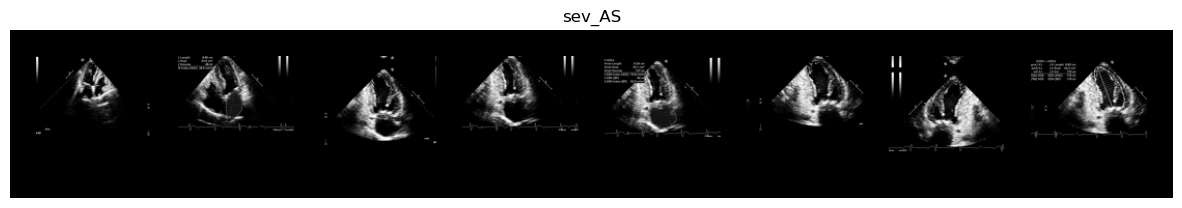

In [14]:
# RUN THIS CELL REPEATEDLY TO SEE DIFFERENT IMAGES
# You can also switch among the different defined datasets to see the different transformations.
# e.g. train_randug_dataset has different transformations from train_dataset

# Unlike the actual test loader for evaluating models, this DataLoader has shuffle=True to preview different images each run
display_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

iter_loader = iter(display_loader)
for _ in range(10):
    show_study_images(iter_loader)

## Models


#### Attention-Based Multiple Instance Learning (ABMIL)

The ABMIL model is the "off-the-shelf" industry-standard model for image attention-based MIL that SAMIL is comparing against. The original Github repo for ABMIL can be found [here](https://github.com/AMLab-Amsterdam/AttentionDeepMIL/tree/master). Because this is a multi-label classification task, the training uses cross-entropy loss.

Generally, it consists of:

1. Three `feature_extractor` layers which generate an embedding of the bag. The first `feature_extractor` layer is a typical CNN layer with pooling and ReLU while the other two are just MLPs.
2. An `attention` layer that learns which images (instances) in the study (bag) to prioritize.
3. A final `classifier` MLP layer that generates class-label logits based on the above two layers.


In [15]:
class Attention(nn.Module):
    def __init__(self, num_classes=3):
        super(Attention, self).__init__()
        self.L = 500
        self.B = 250
        self.D = 128
        self.K = 1
        self.num_classes = num_classes

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # Below layers added in addition to original ABMIL paper
            nn.Conv2d(50, 100, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(100, 200, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(200 * 4 * 4, self.L),
            nn.ReLU(),
        )

        self.feature_extractor_part3 = nn.Sequential(
            nn.Linear(self.L, self.B),
            nn.ReLU(),
            nn.Linear(self.B, self.L),
            nn.ReLU(),
        )

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D), nn.Tanh(), nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L * self.K, self.num_classes),
        )

    def forward(self, x):
        x = x.squeeze(0)

        H = self.feature_extractor_part1(x)
        H = H.view(-1, 200 * 4 * 4)
        H = self.feature_extractor_part2(H)
        H = self.feature_extractor_part3(H)

        A = self.attention(H)
        A = torch.transpose(A, 1, 0)
        A = F.softmax(A, dim=1)  # softmax over number of images

        M = torch.mm(A, H)  # M can be regarded as final representation of this bag

        out = self.classifier(M)  # Outputs logits, not softmax

        return out, A  # A is the attention weights on each image of the bag

In [16]:
# Sanity test for working model

test_attention_model = Attention()
input = torch.randn((1, 9, 3, 112, 112))

num_images = input.shape[1]
label, weights = test_attention_model(input)

assert label.shape == (1, 3), "Labels should match number of classes"
assert weights.shape == (1, num_images), "Weights should match number of studies"

#### Supervised Attention Multiple Instance Learning (SAMIL)

The unique architecutre of SAMIL is the first of the two contributions in this paper. Based off ABMIL, SAMIL introduces the concept of "supervised attention" based on a separate, trained view classifier model. In AS diagnosis, the most relevant views are PLAX and PSAX views which show the aortic valve. With just ABMIL architecture, the attention weights do not sufficiently and correctly prioritize those views as demonstrated in the results section below and in the paper's reported results.

The view classifier is a separately trained model with the task of generating view-relevance scores of whether a specific image is relevant to AS diagnosis. For example, PLAX and PSAX views will have a higher score. To introduce this model in the SAMIL training task of AS diagnosis, a separate loss term called supervised attention is introduced: $\mathcal{L}_{SA}$. This loss term is calculated as the KL-divergence between the attention weights produced by SAMIL during training and the view-relevance scores produced by the view classifier. During training, this loss term will steer the attention weights towards the view-relevance scores.

A problem with enforcing alignment for attention weights is that the ability to train the attention weights is diminished. To remedy this drawback, SAMIL introduces two sets of attention weights instead of ABMIL's one. Only one will be supervised while the other remains flexible, and the two combine to produce the final study (bag) level representation.

$$
z = \sum_{k=1}^{K} c_k h_k, \, c_k(A, B) = \frac{a_k b_k}{\sum_{j=1}^{K} a_j b_j}
$$

$c_k$ is the combined attention weight, which combined with the `feature_extractor` bag-level embedding $h_k$ generates $z$, the final bag-level embedding. $B$ (`A_U` in code) are the flexible, trainable set of attention weights, while $A$ (`A_V` in code) are the weights supervised by view-relevance.


##### View Classifier

The view classifier is based on the Wide ResNet architecture, specifically "WRN-28-2" that has a depth 28 and width 2.
The below code is not modified from the paper's GitHub.

As mentioned above, we will be loading a provided checkpoint for this model.


In [17]:
class BasicBlock(nn.Module):
    def __init__(
        self,
        in_planes,
        out_planes,
        stride,
        drop_rate=0.0,
        activate_before_residual=False,
    ):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=0.001)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(
            in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_planes, momentum=0.001)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv2 = nn.Conv2d(
            out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.drop_rate = drop_rate
        self.equalInOut = in_planes == out_planes
        self.convShortcut = (
            (not self.equalInOut)
            and nn.Conv2d(
                in_planes,
                out_planes,
                kernel_size=1,
                stride=stride,
                padding=0,
                bias=False,
            )
            or None
        )
        self.activate_before_residual = activate_before_residual

    def forward(self, x):
        if not self.equalInOut and self.activate_before_residual == True:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(
        self,
        nb_layers,
        in_planes,
        out_planes,
        block,
        stride,
        drop_rate=0.0,
        activate_before_residual=False,
    ):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(
            block,
            in_planes,
            out_planes,
            nb_layers,
            stride,
            drop_rate,
            activate_before_residual,
        )

    def _make_layer(
        self,
        block,
        in_planes,
        out_planes,
        nb_layers,
        stride,
        drop_rate,
        activate_before_residual,
    ):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(
                block(
                    i == 0 and in_planes or out_planes,
                    out_planes,
                    i == 0 and stride or 1,
                    drop_rate,
                    activate_before_residual,
                )
            )
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, num_classes, depth=28, widen_factor=2, drop_rate=0.0):
        super(WideResNet, self).__init__()
        channels = [
            16,
            16 * widen_factor,
            32 * widen_factor,
            64 * widen_factor,
            128 * widen_factor,
        ]
        assert (depth - 4) % 6 == 0
        n = (depth - 4) / 6  # equivalent to 'repeat' in tf repo
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(
            3, channels[0], kernel_size=3, stride=1, padding=1, bias=False
        )
        # 1st block
        self.block1 = NetworkBlock(
            n,
            channels[0],
            channels[1],
            block,
            1,
            drop_rate,
            activate_before_residual=True,
        )
        # 2nd block
        self.block2 = NetworkBlock(n, channels[1], channels[2], block, 2, drop_rate)
        # 3rd block
        self.block3 = NetworkBlock(n, channels[2], channels[3], block, 2, drop_rate)

        # 4th block (hz added)
        self.block4 = NetworkBlock(n, channels[3], channels[4], block, 2, drop_rate)

        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(channels[4], momentum=0.001)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.fc = nn.Linear(channels[4], num_classes)
        self.channels = channels[4]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode="fan_out", nonlinearity="leaky_relu"
                )
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)

        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.channels)
        return self.fc(out)


def build_wideresnet(depth, widen_factor, dropout, num_classes):
    return WideResNet(
        depth=depth,
        widen_factor=widen_factor,
        drop_rate=dropout,
        num_classes=num_classes,
    )

##### SAMIL Architecture (Similar to ABMIL)


In [18]:
class SAMIL(nn.Module):
    def __init__(self, num_classes=3):
        super(SAMIL, self).__init__()
        self.L = 500
        self.B = 250
        self.D = 128
        self.K = 1
        self.num_classes = num_classes

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # Below layers added in addition to original ABMIL paper
            nn.Conv2d(50, 100, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(100, 200, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(200 * 4 * 4, self.L),
            nn.ReLU(),
        )

        self.feature_extractor_part3 = nn.Sequential(
            nn.Linear(self.L, self.B),
            nn.ReLU(),
            nn.Linear(self.B, self.L),
            nn.ReLU(),
        )

        self.attention_V = nn.Sequential(
            nn.Linear(self.L, self.D), nn.Tanh(), nn.Linear(self.D, self.K)
        )

        self.attention_U = nn.Sequential(
            nn.Linear(self.L, self.D), nn.Tanh(), nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L * self.K, self.num_classes),
        )

    def forward(self, x):
        x = x.squeeze(0)

        H = self.feature_extractor_part1(x)
        H = H.view(-1, 200 * 4 * 4)
        H = self.feature_extractor_part2(H)

        A_V = self.attention_V(H)  # NxK
        A_V = torch.transpose(A_V, 1, 0)  # KxN
        A_V = F.softmax(A_V, dim=1)  # softmax over number of images

        H = self.feature_extractor_part3(H)

        A_U = self.attention_U(H)  # NxK
        A_U = torch.transpose(A_U, 1, 0)  # KxN
        A_U = F.softmax(A_U, dim=1)  # softmax over number of images

        A = torch.exp(
            torch.log(A_V) + torch.log(A_U)
        )  # numerically more stable softmax implementation
        A = A / torch.sum(A)

        M = torch.mm(A, H)  # KxL, M can be regarded as final representation of this bag

        out = self.classifier(M)  # Outputs logits and not softmax

        return out, A_V  # Only view regularize one branch of the attention weights

In [19]:
# Sanity test for working SAMIL model

test_samil_model = SAMIL()
rgb_input = torch.randn((1, 9, 3, 112, 112))

num_images = rgb_input.shape[1]
label, weights = test_samil_model(rgb_input)

assert label.shape == (1, 3), "Labels should match number of classes"
assert weights.shape == (1, num_images), "Weights should match number of studies"

## Training

#### Hyperparameters

We are using the hyperparameters provided in the Appendix of the original paper to reproduce their results. As mentioned above, due to computation constraints, we are only training 1 of the 3 cross-validation splits for our ablations. As such, we are comparing our results to the paper's reported results for that specific split rather than the average results.

Please see the "Training SAMIL" section below for more info on `Temperature` and $\lambda_{SA}$.

| Hyperparameters        | ABMIL  | SAMIL no pretraining | SAMIL img-CL | SAMIL bag pretrain |
| ---------------------- | ------ | -------------------- | ------------ | ------------------ |
| Learning rate          | 0.0008 | 0.0005               | 0.0005       | 0.0005             |
| Weight decay           | 0.0001 | 0.0001               | 0.0001       | 0.0001             |
| Temperature            | \-     | 0.1                  | 0.1          | 0.1                |
| $\lambda_{SA}$         | \-     | 15.0                 | 15.0         | 15.0               |
| Learning rate schedule | Cosine | Cosine               | Cosine       | Cosine             |
| Num Epochs             | 2000   | 2000                 | 2000         | 2000               |

#### Computational Requirements

All training is done locally on an RTX 4080 GPU with Cuda enabled.

All models are trained for 2000 epochs with an early stop if balanced accuracy on the validation set does not improve for 200 consecutive epochs.

| Computational Details         | ABMIL     | SAMIL no pretraining | SAMIL img-CL | SAMIL bag pretrain |
| ----------------------------- | --------- | -------------------- | ------------ | ------------------ |
| Max num epochs                | 2000      | 2000                 | 2000         | 2000               |
| Actual epochs with early stop | 701       | 401                  | 418          | 545                |
| Average time per epoch        | 3s        | 16s                  | 16.2s        | 16.5s              |
| Total runtime                 | 55m 23.1s | 106m 56s             | 121m 20.4s   | 161m 14.4s         |


#### Helper Functions


##### Cosine Scheduler with Warmup

The paper uses a cosine scheduler for learning rate with optional warmup epochs. The optimizer is SGD though Adam was also considered but did not produce better results.


In [20]:
def get_cosine_schedule_with_warmup(
    optimizer,
    lr_warmup_epochs,
    lr_cycle_epochs,  # total train epochs
    num_cycles=7.0 / 16.0,
    last_epoch=-1,
):
    def _lr_lambda(current_epoch):
        if current_epoch < lr_warmup_epochs:
            return float(current_epoch) / float(max(1, lr_warmup_epochs))

        # see if using restart
        ###############################################################
        if current_epoch % lr_cycle_epochs == 0:
            current_cycle_epoch = lr_cycle_epochs
        else:
            current_cycle_epoch = current_epoch % lr_cycle_epochs

        no_progress = float(current_cycle_epoch - lr_warmup_epochs) / float(
            max(1, float(lr_cycle_epochs) - lr_warmup_epochs)
        )
        #################################################################

        return max(0.0, math.cos(math.pi * num_cycles * no_progress))

    return optim.lr_scheduler.LambdaLR(optimizer, _lr_lambda, last_epoch)

##### Saving Model Checkpoints


In [21]:
def save_model_checkpoint(model: Attention | SAMIL, filepath: str):
    torch.save(model.state_dict(), filepath)

##### Eval Function: Balanced Accuracy

Balanced accuracy is the performance metric of choice given the imbalanced nature of TMED-2. More information is explained below in the Results section.


In [22]:
from sklearn.metrics import balanced_accuracy_score


def eval_model(model: Attention | SAMIL, dataloader: DataLoader):
    model.eval()

    with torch.no_grad():
        ground_truth_labels = []
        pred_labels = []

        for data, bag_label in dataloader:
            data, bag_label = data.to(DEVICE), bag_label.to(DEVICE)

            pred_logit, _ = model(data)

            pred_label = torch.softmax(pred_logit, dim=-1)
            pred_label = torch.argmax(pred_label).item()

            pred_labels.append(pred_label)
            ground_truth_labels.append(bag_label.item())

        bal_acc = balanced_accuracy_score(ground_truth_labels, pred_labels)

    return bal_acc

#### Training ABMIL


In [23]:
def train_ABMIL_one_epoch(
    model: Attention,
    train_loader: DataLoader,
    optimizer: optim.SGD | optim.Adam,
    class_weights: torch.Tensor,
):
    model.train()
    train_loss = 0

    for data, label in tqdm(train_loader):
        optimizer.zero_grad()

        data, label = data.to(DEVICE), label.to(DEVICE)

        pred_labels, _ = model(data)
        pred_labels = pred_labels.to(DEVICE)

        loss = F.cross_entropy(pred_labels, label, weight=class_weights)
        loss.backward()
        optimizer.step()

        train_loss += loss.detach().cpu().item()

    train_loss = train_loss / len(train_loader)

    return train_loss

In [24]:
def train_ABMIL_model(
    model: Attention,
    train_loader: DataLoader,
    val_loader: DataLoader,
    test_loader: DataLoader,
    optimizer: optim.SGD | optim.Adam,
    class_weights: torch.Tensor,
    train_csv_path: str,
    val_csv_path: str,
    checkpoint_save_path: str,
    best_checkpoint_save_path: str,
    num_epochs: int,
    eval_freq_epochs: int,
    scheduler=None,
    patience=200,
    early_stop_warmup=500,
):
    model.to(DEVICE)

    train_df = pd.DataFrame(
        index=range(0, num_epochs), columns=["loss"], dtype="Float32"
    )
    val_df = pd.DataFrame(
        index=range(0, num_epochs, eval_freq_epochs),
        columns=["val_bal_acc", "test_bal_acc"],
        dtype="Float32",
    )

    best_val_bal_acc = 0
    best_test_bal_acc = 0
    early_stop_counter = 0

    for epoch in range(num_epochs):
        train_loss = train_ABMIL_one_epoch(
            model, train_loader, optimizer, class_weights
        )
        train_df.loc[epoch] = train_loss

        if scheduler is not None:
            scheduler.step()

        if epoch % eval_freq_epochs == 0:
            val_bal_acc = eval_model(model, val_loader)
            val_df.loc[[epoch], ["val_bal_acc"]] = val_bal_acc

            if val_bal_acc > best_val_bal_acc:
                best_val_bal_acc = val_bal_acc
                early_stop_counter = 0

                test_bal_acc = eval_model(model, test_loader)
                val_df.loc[[epoch], ["test_bal_acc"]] = test_bal_acc

                save_model_checkpoint(model, checkpoint_save_path)

                if test_bal_acc > best_test_bal_acc:
                    best_test_bal_acc = test_bal_acc
                    save_model_checkpoint(model, best_checkpoint_save_path)

            else:
                if epoch > early_stop_warmup:
                    early_stop_counter += 1
                    if early_stop_counter > patience:
                        print(
                            f"Val bal acc has not improved for {patience} cycles, stopping early."
                        )
                        break

            print(
                f"Epoch: {epoch}\t Training Loss: {train_loss:.6f}\t Eval_Bal_Acc: {val_bal_acc}"
            )

    train_df.to_csv(
        train_csv_path, sep=",", header=True, index=True, index_label="epoch"
    )
    val_df.to_csv(val_csv_path, sep=",", header=True, index=True, index_label="epoch")

    print(
        f"Best test bal acc: {best_test_bal_acc}, Best val bal acc: {best_val_bal_acc}"
    )

    return model

Below is the main training loop. Do not run the cell if you do not want to train the model. Alternatively, ensure that `num_epochs` is something low like 2 if you want to verify the code works.


In [25]:
# Hyperparameters from original paper
class_weights = torch.tensor([0.463, 0.342, 0.195]).to(
    DEVICE
)  # Class weights for CrossEntropyLoss from original GitHub
learning_rate = 0.0008  # Learning rate from Appendix Table C.3. ABMIL Split 1
weight_decay = 0.0001  # Weight decay from Appendix Table C.3 ABMIL Split 1
num_epochs = 2  # All training is done with 2000 epochs with early stop from Appendix C
# Also using cosine schedule for all training from Appendix C

eval_freq_epochs = 1  # Frequency of evaluating model's balanced accuracy on val set

if not os.path.exists(os.path.join(RUNS_DIR, "ABMIL")):
    os.makedirs(os.path.join(RUNS_DIR, "ABMIL"))

train_csv = os.path.join(RUNS_DIR, "ABMIL", "train_last_checkpoint.csv")
val_csv = os.path.join(RUNS_DIR, "ABMIL", "val_last_checkpoint.csv")
checkpoint_filepath = os.path.join(RUNS_DIR, "ABMIL", "best_checkpoint.pth.tar")
best_checkpoint_filepath = os.path.join(
    RUNS_DIR, "ABMIL", "best_test_checkpoint.pth.tar"
)
last_checkpoint_filepath = os.path.join(RUNS_DIR, "ABMIL", "last_checkpoint.pth.tar")

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)
ABMIL_model = Attention().to(DEVICE)

no_decay = {"bias", "bn"}

grouped_parameters = [
    {
        "params": [
            p
            for n, p in ABMIL_model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": weight_decay,
    },
    {
        "params": [
            p
            for n, p in ABMIL_model.named_parameters()
            if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

optimizer = optim.SGD(
    grouped_parameters, lr=learning_rate, momentum=0.9, nesterov=True
)  # Momentum and using Nesterov from original GitHub
scheduler = get_cosine_schedule_with_warmup(optimizer, 0, num_epochs)  # Cosine schedule

ABMIL_model = train_ABMIL_model(
    ABMIL_model,
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    class_weights,
    train_csv,
    val_csv,
    checkpoint_filepath,
    best_checkpoint_filepath,
    num_epochs,
    eval_freq_epochs,
    scheduler=scheduler,
)

save_model_checkpoint(ABMIL_model, last_checkpoint_filepath)

100%|██████████| 360/360 [00:04<00:00, 72.33it/s]


Epoch: 0	 Training Loss: 1.086984	 Eval_Bal_Acc: 0.3333333333333333


100%|██████████| 360/360 [00:03<00:00, 90.61it/s] 


Epoch: 1	 Training Loss: 1.048362	 Eval_Bal_Acc: 0.3333333333333333
Best test bal acc: 0.3333333333333333, Best val bal acc: 0.3333333333333333


#### Training SAMIL

As mentioned above we are using a provided checkpoint for the view classifier available on the original paper's Github.

SAMIL training introduces two new hyperparamters: `temperature` (T) and `lambda_view_regularization` ($\lambda_{SA}$).

`temperature` is used to scale the view relevance probabilities from the view classifier in the softmax transform.
View relevance probability is defined as the sum of the probabilitiy that the specific image is PLAX or PSAX.
Note that PLAX or PSAX are the only views that show the aortic valve and are relevant to AS diagnosis.

`lambda_view_regualarization` is a scalar value used to balance the loss function between cross-entropy loss (which is the only loss function in ABMIL) and supervised attention loss, which is the KL-divergence between view relevance scores and produced attention weights as mentioned above.

The total loss function for SAMIL now accounts for the original CELoss from ABMIL as well as a supervised attention loss from the KL divergence between SAMIL's attention weights and the view relevance classifier weights.

$$
    \mathcal{L} = \mathcal{L}_{CE} + \lambda_{SA}\mathcal{L}_{SA}
$$


In [26]:
def create_view_model(pretrained=True):
    view_model = build_wideresnet(depth=28, widen_factor=2, dropout=0.0, num_classes=3)

    # load the saved checkpoint
    if pretrained:
        view_checkpoint_path = os.path.join(
            CHECKPOINTS_DIR, "view_classifier", "seed0_model_best.pth.tar"
        )
        view_checkpoint = torch.load(view_checkpoint_path)
        view_model.load_state_dict(view_checkpoint["ema_state_dict"])
        view_model.eval()

    return view_model

In [27]:
# Sanity test for View Model
temperature = 0.1  # Hyperparameter for training SAMIL, explained below

test_view_model = create_view_model()

rgb_input = torch.randn((1, 9, 3, 112, 112))

num_images = rgb_input.shape[1]

with torch.no_grad():
    view_predictions = test_view_model(rgb_input.squeeze(0))
    softmax_view_predictions = F.softmax(view_predictions, dim=1)

    # The first two indices indicate probabilities of image being a PLAX or PSAX view
    predicted_relevance = softmax_view_predictions[:, :2]

    # Summing the two generates a probability of the view being relevant to diagnosing AS
    predicted_relevance = torch.sum(predicted_relevance, dim=1)

    predicted_relative_relevance = F.softmax(predicted_relevance / temperature, dim=-1)
    predicted_relative_relevance = predicted_relative_relevance.unsqueeze(0)

assert predicted_relative_relevance.shape == (
    1,
    num_images,
), "Weights should match number of studies"

In [28]:
def train_SAMIL_one_epoch(
    model: Attention,
    view_model: WideResNet,
    train_loader: DataLoader,
    optimizer: optim.SGD | optim.Adam,
    class_weights: torch.Tensor,
    temperature: float,
    lambda_view_regularization: float,
    cur_epoch: int,
    view_regularization_warmup_pos: float,
):
    model.train()
    view_model.eval()
    train_loss = 0

    for data, label in tqdm(train_loader):
        optimizer.zero_grad()

        data, label = data.to(DEVICE), label.to(DEVICE)

        pred_label, attentions = model(data)
        pred_label, attentions = pred_label.to(DEVICE), attentions.to(DEVICE)

        log_attentions = torch.log(attentions)

        # Get predicted view relevance for each image from pretrained view classifier
        with torch.no_grad():
            view_predictions = view_model(data.squeeze(0))
            view_predictions = view_predictions.to(DEVICE)

            softmax_view_predictions = F.softmax(view_predictions, dim=1)

            predicted_relevance = softmax_view_predictions[:, :2]
            predicted_relevance = torch.sum(predicted_relevance, dim=1)

            predicted_relative_relevance = F.log_softmax(
                predicted_relevance / temperature, dim=-1
            )
            predicted_relative_relevance = predicted_relative_relevance.unsqueeze(0)

        CE_Loss = F.cross_entropy(pred_label, label, class_weights)
        ViewRegularization_Loss = F.kl_div(
            input=log_attentions,
            target=predicted_relative_relevance,
            log_target=True,
            reduction="batchmean",
        )

        current_warmup = np.clip(
            cur_epoch / (float(view_regularization_warmup_pos) * num_epochs),
            0,
            1,
        )

        total_loss = (
            CE_Loss
            + lambda_view_regularization * ViewRegularization_Loss * current_warmup
        )

        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.detach().cpu().item()

    train_loss = train_loss / len(train_loader)

    return train_loss

In [29]:
view_regularization_warmup_pos = 0.4


def train_SAMIL_model(
    model: SAMIL,
    view_model: WideResNet,
    train_loader: DataLoader,
    val_loader: DataLoader,
    test_loader: DataLoader,
    optimizer: optim.SGD | optim.Adam,
    train_csv_path: str,
    val_csv_path: str,
    checkpoint_save_path: str,
    best_checkpoint_save_path: str,
    class_weights: torch.Tensor,
    num_epochs: int,
    eval_freq_epochs: int,
    temperature: float,
    lambda_view_regularization: float,
    scheduler=None,
    patience=200,
    early_stop_warmup=200,
):
    model.to(DEVICE)
    view_model.to(DEVICE)

    train_df = pd.DataFrame(
        index=range(0, num_epochs), columns=["loss"], dtype="Float32"
    )
    val_df = pd.DataFrame(
        index=range(0, num_epochs, eval_freq_epochs),
        columns=["val_bal_acc", "test_bal_acc"],
        dtype="Float32",
    )

    best_val_bal_acc = 0
    best_test_bal_acc = 0
    early_stop_counter = 0

    for epoch in range(num_epochs):
        train_loss = train_SAMIL_one_epoch(
            model,
            view_model,
            train_loader,
            optimizer,
            class_weights,
            temperature,
            lambda_view_regularization,
            epoch,
            view_regularization_warmup_pos,
        )
        train_df.loc[epoch] = train_loss

        if scheduler is not None:
            scheduler.step()

        if epoch % eval_freq_epochs == 0:
            val_bal_acc = eval_model(model, val_loader)
            val_df.loc[[epoch], ["val_bal_acc"]] = val_bal_acc

            if val_bal_acc > best_val_bal_acc:
                best_val_bal_acc = val_bal_acc
                early_stop_counter = 0

                test_bal_acc = eval_model(model, test_loader)
                val_df.loc[[epoch], ["test_bal_acc"]] = test_bal_acc

                save_model_checkpoint(model, checkpoint_save_path)

                if test_bal_acc > best_test_bal_acc:
                    best_test_bal_acc = test_bal_acc
                    save_model_checkpoint(model, best_checkpoint_save_path)

            else:
                if epoch > early_stop_warmup:
                    early_stop_counter += 1
                    if early_stop_counter > patience:
                        print(
                            f"Val bal acc has not improved for {patience} cycles, stopping early."
                        )
                        break

            print(
                f"Epoch: {epoch}\t Training Loss: {train_loss:.6f}\t Eval_Bal_Acc: {val_bal_acc}"
            )

    train_df.to_csv(
        train_csv_path, sep=",", header=True, index=True, index_label="epoch"
    )
    val_df.to_csv(val_csv_path, sep=",", header=True, index=True, index_label="epoch")

    print(
        f"Best val bal acc: {best_val_bal_acc}, Best test bal acc: {best_test_bal_acc}"
    )

    return model

##### Training SAMIL - No Pretrain

Below is the main training loop. Do not run the cell if you do not want to train the model. Alternatively, ensure that `num_epochs` is something low like 2 if you want to verify the code works.


In [30]:
# Hyperparameters from original paper
class_weights = torch.tensor([0.463, 0.342, 0.195]).to(
    torch.device("cuda")
)  # Class weights for CrossEntropyLoss from original GitHub
learning_rate = 0.0005  # Learning rate from Appendix Table C.3. ABMIL Split 1
weight_decay = 0.0001  # Weight decay from Appendix Table C.3 ABMIL Split 1

temperature = 0.1  # Temperature from Appendix Table C.1 SAMIL Split 1
lambda_view_regularization = 15.0  # Lambda_SA from Appendix Table C.1 SAMIL Split 1

num_epochs = 2  # All training is done with 2000 epochs with early stop from Appendix C
# Also using cosine schedule for all training from Appendix C

eval_freq_epochs = 1  # Frequency of evaluating model's balanced accuracy on val set

if not os.path.exists(os.path.join(RUNS_DIR, "SAMIL-no-pretrain")):
    os.makedirs(os.path.join(RUNS_DIR, "SAMIL-no-pretrain"))

train_csv = os.path.join(RUNS_DIR, "SAMIL-no-pretrain", "train_last_checkpoint.csv")
val_csv = os.path.join(RUNS_DIR, "SAMIL-no-pretrain", "val_last_checkpoint.csv")
checkpoint_filepath = os.path.join(
    RUNS_DIR, "SAMIL-no-pretrain", "best_checkpoint.pth.tar"
)
best_checkpoint_filepath = os.path.join(
    RUNS_DIR, "SAMIL-no-pretrain", "best_test_checkpoint.pth.tar"
)
last_checkpoint_filepath = os.path.join(
    RUNS_DIR, "SAMIL-no-pretrain", "last_checkpoint.pth.tar"
)

train_loader = DataLoader(
    train_randaug_dataset, batch_size=1, shuffle=True, num_workers=8
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)
SAMIL_model = SAMIL().to(DEVICE)
view_model = create_view_model().to(DEVICE)

no_decay = {"bias", "bn"}

grouped_parameters = [
    {
        "params": [
            p
            for n, p in SAMIL_model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": weight_decay,
    },
    {
        "params": [
            p
            for n, p in SAMIL_model.named_parameters()
            if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

optimizer = optim.SGD(grouped_parameters, lr=learning_rate, momentum=0.9, nesterov=True)
scheduler = get_cosine_schedule_with_warmup(optimizer, 0, num_epochs)

SAMIL_model = train_SAMIL_model(
    SAMIL_model,
    view_model,
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    train_csv,
    val_csv,
    checkpoint_filepath,
    best_checkpoint_filepath,
    class_weights,
    num_epochs,
    eval_freq_epochs,
    temperature,
    lambda_view_regularization,
    scheduler=scheduler,
)

save_model_checkpoint(SAMIL_model, last_checkpoint_filepath)

100%|██████████| 360/360 [00:18<00:00, 19.46it/s]


Epoch: 0	 Training Loss: 1.091212	 Eval_Bal_Acc: 0.3333333333333333


100%|██████████| 360/360 [00:17<00:00, 20.25it/s]


Epoch: 1	 Training Loss: 21.574795	 Eval_Bal_Acc: 0.3333333333333333
Best val bal acc: 0.3333333333333333, Best test bal acc: 0.3333333333333333


##### Training SAMIL - MoCo Pretraining

For the second contribution of bag-level pretraining, the paper describes a pretraining strategy that builds upon MoCo, a recent method for self-supervised image-level contrastive learning (img-CL).

Self-superved learning (SSL) is a way to pre-train models that can be used for downstream tasks. The main idea is for the learned embedding of a training image to be similar to embeddings of slight transformations of the image while still being different from embeddings of other training images. The corresponding loss function is called InfoNCE where NCE stands for Noise-Contrastive Estimation, involving positive samples (similar samples) and negative samples (dissimilar samples).

"To obtain "similar" images, each image goes through different transformations to yield two versions of itself. These images are then encoded into an $L$-dimensional feature space by composing a projection layer... onto the output of the instance-level representation layer $f$" (10). Note that here, $f$ represents the embedding of an image, not of the entire bag or study. To obtain "dissimilar" images, MoCo retrieves some previous embeddings, usually in the same training batch, which are treated as "negative keys".

It is important to note that MoCo is a pre-training task, meaning the architecture/implementation of SAMIL is still the same as without pretraining. MoCo trains a model where there is a projection layer on top of the feature extraction layers of SAMIL. By training this model with this different objective, the feature extraction layers can be pre-trained with weights that generate a richer embedding with an ability to be similar to similar images (i.e. images from a study with the same label) and dissimilar from dissimilar images (i.e. images from a study with a different label). At the end of MoCo training, the projection layer can be discarded, leaving only the feature extraction layer weights for use in the original SAMIL training task. It is like giving the SAMIL model a warm start to its original objective.

Note that the original GitHub does not include the code for MoCo training, only the pretrained checkpoints, so for this ablation and the next (bag-level MoCo), we are only loading the pretrained weights and applying them to SAMIL before training.


In [31]:
# Loading pretrained checkpoint either for MoCO instance-level or bag-level

from collections import OrderedDict


def create_pretrained_SAMIL_model(checkpoint_path):
    model = SAMIL()

    if checkpoint_path != "":
        print("Loading pretrained weights")

        pretrained_dict = torch.load(checkpoint_path)
        new_state_dict = OrderedDict()

        for k, v in pretrained_dict.items():
            if "encoder_q" in k:
                name = ".".join(k.split(".")[1:])
                new_state_dict[name] = v

        model_dict = model.state_dict()

        new_state_dict = {k: v for k, v in new_state_dict.items() if k in model_dict}
        model_dict.update(new_state_dict)

        model.load_state_dict(model_dict)

    return model

##### Training SAMIL - img-CL

Below is the main training loop. Do not run the cell if you do not want to train the model. Alternatively, ensure that `num_epochs` is something low like 2 if you want to verify the code works.


In [32]:
# Hyperparameters from original paper, these are the same for all SAMIL ablations
class_weights = torch.tensor([0.463, 0.342, 0.195]).to(
    DEVICE
)  # Class weights for CrossEntropyLoss from original GitHub
weight_decay = 0.0001  # Weight decay from Appendix Table C.1 SAMIL Split 1
learning_rate = 0.0005  # Learning rate from Appendix Table C.1 SAMIL Split 1

temperature = 0.1  # Temperature from Appendix Table C.1 SAMIL Split 1
lambda_view_regularization = 15.0  # Lambda_SA from Appendix Table C.1 SAMIL Split 1

num_epochs = 2  # All training is done with 2000 epochs with early stop from Appendix C
# Also using cosine schedule for all training from Appendix C

eval_freq_epochs = 1  # Frequency of evaluating model's balanced accuracy on val set

if not os.path.exists(os.path.join(RUNS_DIR, "SAMIL-imgcl")):
    os.makedirs(os.path.join(RUNS_DIR, "SAMIL-imgcl"))

train_csv = os.path.join(RUNS_DIR, "SAMIL-imgcl", "train_last_checkpoint.csv")
val_csv = os.path.join(RUNS_DIR, "SAMIL-imgcl", "val_last_checkpoint.csv")
checkpoint_filepath = os.path.join(RUNS_DIR, "SAMIL-imgcl", "best_checkpoint.pth.tar")
best_checkpoint_filepath = os.path.join(
    RUNS_DIR, "SAMIL-imgcl", "best_test_checkpoint.pth.tar"
)
last_checkpoint_filepath = os.path.join(
    RUNS_DIR, "SAMIL-imgcl", "last_checkpoint.pth.tar"
)

train_loader = DataLoader(
    train_randaug_dataset, batch_size=1, shuffle=True, num_workers=8
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

pretrained_path = os.path.join(
    CHECKPOINTS_DIR, "MOCO_Pretraining_ImageLevel", "seed0_checkpoint.pt"
)
SAMIL_imgcl_model = create_pretrained_SAMIL_model(pretrained_path).to(DEVICE)
view_model = create_view_model().to(DEVICE)

no_decay = {"bias", "bn"}

grouped_parameters = [
    {
        "params": [
            p
            for n, p in SAMIL_imgcl_model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": weight_decay,
    },
    {
        "params": [
            p
            for n, p in SAMIL_imgcl_model.named_parameters()
            if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

optimizer = optim.SGD(grouped_parameters, lr=learning_rate, momentum=0.9, nesterov=True)
scheduler = get_cosine_schedule_with_warmup(optimizer, 0, num_epochs)

SAMIL_imgcl_model = train_SAMIL_model(
    SAMIL_imgcl_model,
    view_model,
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    train_csv,
    val_csv,
    checkpoint_filepath,
    best_checkpoint_filepath,
    class_weights,
    num_epochs,
    eval_freq_epochs,
    temperature,
    lambda_view_regularization,
    scheduler=scheduler,
)

save_model_checkpoint(SAMIL_imgcl_model, last_checkpoint_filepath)

Loading pretrained weights


100%|██████████| 360/360 [00:18<00:00, 19.79it/s]


Epoch: 0	 Training Loss: 1.096851	 Eval_Bal_Acc: 0.3333333333333333


100%|██████████| 360/360 [00:17<00:00, 20.25it/s]


Epoch: 1	 Training Loss: 10.564183	 Eval_Bal_Acc: 0.3333333333333333
Best val bal acc: 0.3333333333333333, Best test bal acc: 0.3333333333333333


##### Training SAMIL - "Bag-level" Pretraining

This ablation is the proposed SAMIL model with both contributions and should theoretically have the best performance of all ablations.

MoCo is adapted to self-supervised learning at the bag-level rather than image/instance-level. The overall idea is the same, but the method is modified to find similar "bags" or studies rather than similar "instances" or images. InfoNCE loss is also correspondingly changed.

Just like img-CL, the MoCo implementation and training code are not provided, and only the pretrained weights for the feature extraction layers of SAMIL are provided.

Below is the main training loop. Do not run the cell if you do not want to train the model. Alternatively, ensure that `num_epochs` is something low like 2 if you want to verify the code works.


In [33]:
# Hyperparameters from original paper, these are the same for all SAMIL ablations
class_weights = torch.tensor([0.463, 0.342, 0.195]).to(
    DEVICE
)  # Class weights for CrossEntropyLoss from original GitHub
learning_rate = 0.0005  # Learning rate from Appendix Table C.1. SAMIL Split 1
weight_decay = 0.0001  # Weight decay from Appendix Table C.1 SAMIL Split 1

temperature = 0.1  # Temperature from Appendix Table C.1 SAMIL Split 1
lambda_view_regularization = 15.0  # Lambda_SA from Appendix Table C.1 SAMIL Split 1

num_epochs = 2  # All training is done with 2000 epochs with early stop from Appendix C
# Also using cosine schedule for all training from Appendix C

eval_freq_epochs = 1  # Frequency of evaluating model's balanced accuracy on val set

if not os.path.exists(os.path.join(RUNS_DIR, "SAMIL-bag-pretrain")):
    os.makedirs(os.path.join(RUNS_DIR, "SAMIL-bag-pretrain"))

train_csv = os.path.join(RUNS_DIR, "SAMIL-bag-pretrain", "train_last_checkpoint.csv")
val_csv = os.path.join(RUNS_DIR, "SAMIL-bag-pretrain", "val_last_checkpoint.csv")
checkpoint_filepath = os.path.join(
    RUNS_DIR, "SAMIL-bag-pretrain", "best_checkpoint.pth.tar"
)
best_checkpoint_filepath = os.path.join(
    RUNS_DIR, "SAMIL-bag-pretrain", "best_test_checkpoint.pth.tar"
)
last_checkpoint_filepath = os.path.join(
    RUNS_DIR, "SAMIL-bag-pretrain", "last_checkpoint.pth.tar"
)

train_loader = DataLoader(
    train_randaug_dataset, batch_size=1, shuffle=True, num_workers=8
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

pretrained_path = os.path.join(
    CHECKPOINTS_DIR, "MOCO_Pretraining_StudyLevel", "seed0_checkpoint.pt"
)
SAMIL_bag_pretrain_model = create_pretrained_SAMIL_model(pretrained_path).to(DEVICE)
view_model = create_view_model().to(DEVICE)

no_decay = {"bias", "bn"}

grouped_parameters = [
    {
        "params": [
            p
            for n, p in SAMIL_bag_pretrain_model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": weight_decay,
    },
    {
        "params": [
            p
            for n, p in SAMIL_bag_pretrain_model.named_parameters()
            if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

optimizer = optim.SGD(grouped_parameters, lr=learning_rate, momentum=0.9, nesterov=True)
scheduler = get_cosine_schedule_with_warmup(optimizer, 0, num_epochs)

SAMIL_bag_pretrain_model = train_SAMIL_model(
    SAMIL_bag_pretrain_model,
    view_model,
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    train_csv,
    val_csv,
    checkpoint_filepath,
    best_checkpoint_filepath,
    class_weights,
    num_epochs,
    eval_freq_epochs,
    temperature,
    lambda_view_regularization,
    scheduler=scheduler,
)

save_model_checkpoint(SAMIL_bag_pretrain_model, last_checkpoint_filepath)

Loading pretrained weights


100%|██████████| 360/360 [00:18<00:00, 19.99it/s]


Epoch: 0	 Training Loss: 1.087973	 Eval_Bal_Acc: 0.3333333333333333


100%|██████████| 360/360 [00:17<00:00, 20.34it/s]


Epoch: 1	 Training Loss: 16.394033	 Eval_Bal_Acc: 0.3333333333333333
Best val bal acc: 0.3333333333333333, Best test bal acc: 0.3333333333333333


## Evaluation

We are using balanced accuracy as the performance metric for evaluation just like the original paper. The TMED-2 dataset is fairly imbalanced, favoring more studies with a severe AS label, meaning standard accuracy is not suitable.

Based on the original repo's code, we use the following process of evaluating the model during the training loop.

1. Evaluate the model on the validation set with a specified frequency. The default is every epoch.

2. If there is a new best balanced accuracy recorded, evaluate the model on the test set. The final reported balanced accuracy is the best test accuracy encountered during training.

3. Else, continue training the model until balanced accuracy on the validation set does not improve for a specified number of epochs. This is the `patience` parameter (default 200) and only starts counting after the first `early_stop_warmup` epochs (default 200) have elapsed.

**Note**: Please see the section under Training -> Helper Functions -> Eval Function: Balanced Accuracy for the implementation code of the evaluation metric.

The code in the sections below will load saved checkpoints of each model where the best balanced accuracy on the test set was encountered and evaluate balanced accuracy on the test set using the defined helper function above.


#### Testing ABMIL


In [34]:
paper_ABMIL_bal_acc = (
    0.585  # Original paper's balanced accuracy for Split 1 from Table 3 and 4
)

# Testing by loading a saved checkpoint
load_model_path = os.path.join(
    ARCHIVED_RUNS_DIR, "ABMIL-52.5", "best_test_checkpoint.pth.tar"
)

loaded_ABMIL_model = Attention().to(DEVICE)
loaded_ABMIL_model.load_state_dict(torch.load(load_model_path))

loaded_ABMIL_model.eval()

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)
bal_acc = eval_model(loaded_ABMIL_model, test_loader)

print(f"Paper's bal_acc: {paper_ABMIL_bal_acc}")
print(f"Bal_acc: {bal_acc}")

Paper's bal_acc: 0.585
Bal_acc: 0.52473604826546


#### Testing SAMIL with No Pretraining


In [35]:
paper_NoPretrain_SAMIL_bal_acc = 0.727

# Testing by loading a saved checkpoint
load_model_path = os.path.join(
    ARCHIVED_RUNS_DIR, "SAMIL-70.2", "best_test_checkpoint.pth.tar"
)

loaded_SAMIL_Model = SAMIL().to(DEVICE)
loaded_SAMIL_Model.load_state_dict(torch.load(load_model_path))

loaded_SAMIL_Model.eval()

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)
bal_acc = eval_model(loaded_SAMIL_Model, test_loader)

print(f"Paper's bal_acc: {paper_NoPretrain_SAMIL_bal_acc}")
print(f"Bal_acc: {bal_acc}")

Paper's bal_acc: 0.727
Bal_acc: 0.7024886877828055


#### Testing SAMIL with img-CL


In [36]:
paper_ImgCL_SAMIL_bal_acc = 0.712

# Testing by loading a saved checkpoint
load_model_path = os.path.join(
    ARCHIVED_RUNS_DIR, "SAMIL-imgcl-70.3", "best_test_checkpoint.pth.tar"
)

loaded_SAMIL_Model = SAMIL().to(DEVICE)
loaded_SAMIL_Model.load_state_dict(torch.load(load_model_path))

loaded_SAMIL_Model.eval()

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)
bal_acc = eval_model(loaded_SAMIL_Model, test_loader)

print(f"Paper's bal_acc: {paper_ImgCL_SAMIL_bal_acc}")
print(f"Bal_acc: {bal_acc}")

Paper's bal_acc: 0.712
Bal_acc: 0.703318250377074


#### Testing SAMIL with Pretraining


In [37]:
paper_Pretrain_SAMIL_bal_acc = 0.754

# Testing by loading a saved checkpoint
load_model_path = os.path.join(
    ARCHIVED_RUNS_DIR, "SAMIL-bag-pretrain-72.9", "best_test_checkpoint.pth.tar"
)

loaded_SAMIL_Model = SAMIL().to(torch.device("cuda"))
loaded_SAMIL_Model.load_state_dict(torch.load(load_model_path))

loaded_SAMIL_Model.eval()

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)
bal_acc = eval_model(loaded_SAMIL_Model, test_loader)

print(f"Paper's bal_acc: {paper_Pretrain_SAMIL_bal_acc}")
print(f"Bal_acc: {bal_acc}")

Paper's bal_acc: 0.754
Bal_acc: 0.7291101055806938


# Results

Below are our results compared to the paper's reported results on Split 1.

| Ablation           | Reported Bal. Acc. | Our Bal. Acc. |
| ------------------ | ------------------ | ------------- |
| ABMIL              | 58.5               | 52.5          |
| SAMIL no pretrain  | 72.7               | 70.2          |
| SAMIL img-CL       | 71.2               | 70.3          |
| SAMIL bag pretrain | 75.4               | 72.9          |

Based on our reported results, we believe that we have been able to sufficiently reproduce the paper's produced results with minor deviations likely due to randomness and other variance. Our ABMIL results are the most different from the paper's likely due to the model itself being the most primitive and therefore being susceptible to the most variance in training results.

Our results suggest that the paper's proposed contributions are indeed valuable to AS screening and can be applied to other image-related attention-based MIL tasks. There are limitations to our findings as we only trained one split out of the three provided cross-validation splits. Additionally, based on further analysis on plots as shown below, our findings suggest that the contribution of SAMIL bag pretraining is not as valuable and significant as the supervised attention mechanism contribution. We believe this aligns with the paper's reported ablation studies as well since they report around a 2.7% improvement between SAMIL with no pretraining and SAMIL with bag pretraining in Split 1.


## Analysis

**Note**: To be able to run the below code, ensure that you have downloaded our archived model runs either using `gdown` with the code in the Setup section or manually.


##### Comparing Train Loss over Epochs for each Ablation

It is worth noting that comparing mean loss per epoch between SAMIL runs and ABMIL is not completely fair since ABMIL's loss is only CELoss while SAMIL's loss is CELoss + a supervised attention loss term. This chart is still valuable in demonstrating other key observations:

1. ABMIL takes longer to train and achieves diminishing returns on reducing loss per epoch later than SAMIL. This result would suggest that MoCo pretraining has some value as a warm start to training, but even SAMIL with no pretraining (orange) largely matches the curve of SAMIL with bag pretraining (green), only having a higher peak loss at the very beginning. SAMIL with image pretraining (purple) also interestingly seems to outperform the other two SAMIL runs though the final balanced accuracy metrics indicate otherwise.
2. SAMIL models reach significant loss reduction (more effective training) per epoch faster than ABMIL, but the range of loss reduction is potentially less than ABMIL. Again, this result is likely because the loss function of SAMIL comprises two loss terms.


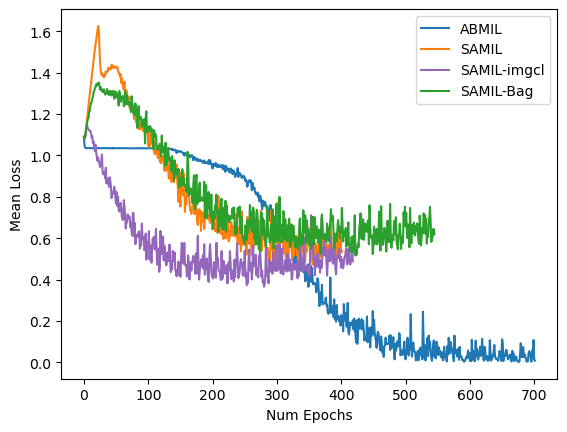

In [38]:
ABMIL_df = pd.read_csv(
    os.path.join(ARCHIVED_RUNS_DIR, "ABMIL-52.5", "train_last_checkpoint.csv")
)
SAMIL_df = pd.read_csv(
    os.path.join(ARCHIVED_RUNS_DIR, "SAMIL-70.2", "train_last_checkpoint.csv")
)
SAMIL_imgcl_df = pd.read_csv(
    os.path.join(ARCHIVED_RUNS_DIR, "SAMIL-imgcl-70.3", "train_last_checkpoint.csv")
)
SAMIL_bag_df = pd.read_csv(
    os.path.join(
        ARCHIVED_RUNS_DIR, "SAMIL-bag-pretrain-72.9", "train_last_checkpoint.csv"
    )
)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(ABMIL_df["epoch"], ABMIL_df["loss"], color="tab:blue", label="ABMIL")
ax.plot(SAMIL_df["epoch"], SAMIL_df["loss"], color="tab:orange", label="SAMIL")
ax.plot(
    SAMIL_imgcl_df["epoch"],
    SAMIL_imgcl_df["loss"],
    color="tab:purple",
    label="SAMIL-imgcl",
)
ax.plot(
    SAMIL_bag_df["epoch"], SAMIL_bag_df["loss"], color="tab:green", label="SAMIL-Bag"
)

plt.xlabel("Num Epochs")
plt.ylabel("Mean Loss")
plt.legend(loc="upper right")
plt.show()

##### Comparing Balanced Accuracy over Epochs for each Ablation

The following plots significantly suggest that SAMIL does indeed outperform ABMIL in balanced accuracy on the validation set throughout training. But, SAMIL with MoCo bag pretraining does not immediately seem to outperform SAMIL with no pretraining and SAMIL with MoCo image pretraining. This result can also be seen as more or less in line with what the paper reports as there is only a 2.7% improvement on SAMIL with no pretraining.


In [39]:
from matplotlib.pyplot import Axes


def draw_trend_line(
    ax: Axes,
    csv_path: str,
    x_col: str,
    y_col: str,
    color: str,
    label: str,
    curve_degree: int,
):
    df = pd.read_csv(csv_path)
    df = df[pd.notna(df[y_col])]

    z = np.polyfit(df[x_col], df[y_col], curve_degree)
    p = np.poly1d(z)

    ax.plot(df[x_col], p(df[x_col]), color=color, label=label)

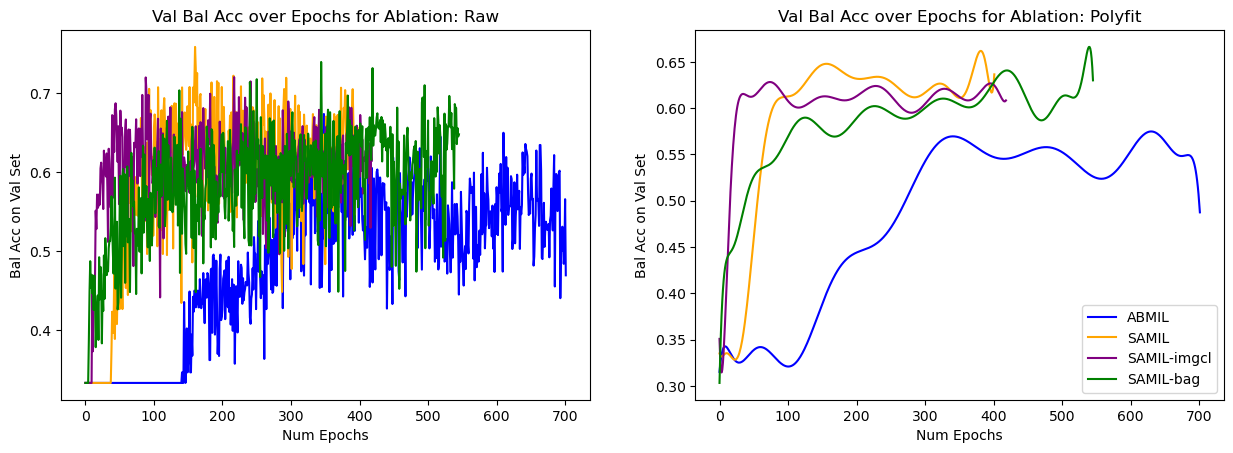

In [40]:
ABMIL_path = os.path.join(ARCHIVED_RUNS_DIR, "ABMIL-52.5", "val_last_checkpoint.csv")
SAMIL_path = os.path.join(ARCHIVED_RUNS_DIR, "SAMIL-70.2", "val_last_checkpoint.csv")
SAMIL_imgcl_path = os.path.join(
    ARCHIVED_RUNS_DIR, "SAMIL-imgcl-70.3", "val_last_checkpoint.csv"
)
SAMIL_bag_path = os.path.join(
    ARCHIVED_RUNS_DIR, "SAMIL-bag-pretrain-72.9", "val_last_checkpoint.csv"
)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
# ax = fig.add_subplot(1, 1, 1)
draw_trend_line(ax2, ABMIL_path, "epoch", "val_bal_acc", "blue", "ABMIL", 16)
draw_trend_line(ax2, SAMIL_path, "epoch", "val_bal_acc", "orange", "SAMIL", 16)
draw_trend_line(
    ax2, SAMIL_imgcl_path, "epoch", "val_bal_acc", "purple", "SAMIL-imgcl", 16
)
draw_trend_line(ax2, SAMIL_bag_path, "epoch", "val_bal_acc", "green", "SAMIL-bag", 16)

ax1.plot(
    "epoch", "val_bal_acc", data=pd.read_csv(ABMIL_path), color="blue", label="ABMIL"
)
ax1.plot(
    "epoch", "val_bal_acc", data=pd.read_csv(SAMIL_path), color="orange", label="SAMIL"
)
ax1.plot(
    "epoch",
    "val_bal_acc",
    data=pd.read_csv(SAMIL_imgcl_path),
    color="purple",
    label="SAMIL-imgcl",
)
ax1.plot(
    "epoch",
    "val_bal_acc",
    data=pd.read_csv(SAMIL_bag_path),
    color="green",
    label="SAMIL-Bag",
)

ax1.set_title("Val Bal Acc over Epochs for Ablation: Raw")
ax2.set_title("Val Bal Acc over Epochs for Ablation: Polyfit")
ax1.set_xlabel("Num Epochs")
ax2.set_xlabel("Num Epochs")
ax1.set_ylabel("Bal Acc on Val Set")
ax2.set_ylabel("Bal Acc on Val Set")
plt.legend(loc="lower right")
plt.show()

# Discussion

We believe that the original paper is definitely reproducible given how closely our results match the reported results.

The original code was already almost fully working without any significant bugs or deprecated methods, making it easy to adapt to our current notebook. The paper's appendix also provided most of the hyperparameters for each ablation for reproducing their results.

The only major change and difficulty in reproducing the paper was that the original dataset used tiff files with video frames while the provided dataset was in PNG form. The folder structure was also different, and as such, we had to adapt the `EchoDataset` class to fit the new dataset format.

Originally, the patient IDs also did not match the released dataset's patient IDs; however, we reached out to contact the original authors who prompty made accomodating changes to their original repository. We are extremely grateful especially to Zhe Huang who wrote much of the original code, was helpful in explaining many different parts, and pushed several updates to the original repo to accomodate our challenges.

For example, one major miscommunication we had during the process was when to measure balanced accuracy during training. We started off training each model for the full 2000 epochs and evaluated balanced accuracy on the test set at the very end; however, our balanced accuracy results were on average 5% worse than the paper's reported ones. After some communication with the original authors, we realized that they measure balanced accuracy on the test set upon encountering a new best balanced accuracy on the validation set. The final reported metrics are the best test balanced accuracy throughout the training process. Upon modifying our training loop, we were able to more closely match the results of the paper.

Our recommendations for future reproducibility are to especially take note of when to measure balanced acccuracy. Another discrepancy we noticed is that the SAMIL runs use the `RandAug` transformations while the ABMIL run uses a different set of transformations. Because the pretrained MoCo weights are trained on `RandAug`, we did not want to standardize the transformations across the different models as doing so might produce different results. We believe that future ablations should either standardize the transformations to all be `RandAug` or a different set.


# References

Citation for the original paper:

```
@article {
    huang2023detecting,
    title={Detecting Heart Disease from Multi-View Ultrasound Images via Supervised Attention Multiple Instance Learning},
    author={Huang, Zhe and Wessler, Benjamin S and Hughes, Michael C},
    journal={arXiv preprint arXiv:2306.00003},
    year={2023}
}









```
